In [ ]:
# importing the numpy library
import numpy as np

In [ ]:
# importing the pandas library
import pandas as pd

In [ ]:
# importing the datasets and concatenating them into one dataframe

data1 = pd.read_csv('jester-data-1.csv', header = None)
data2 = pd.read_csv('jester-data-2.csv', header = None)
data3 = pd.read_csv('jester-data-3.csv', header = None)


data = pd.concat([data1, data2, data3])

In [ ]:
# displaying top 5 rows of the dataset
data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,74,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,100,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,49,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,48,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,91,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


In [ ]:
# checking the type of the dataset ie., dataframe
type(data)

pandas.core.frame.DataFrame

In [ ]:
# dataset description and number of records present in the dataset (number of unique users)
data.info()
len(data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73421 entries, 0 to 24937
Columns: 101 entries, 0 to 100
dtypes: float64(100), int64(1)
memory usage: 57.1 MB


73421

In [ ]:
# selecting the user-ratings of the fixed 100 jokes
X = np.array(data)[:,1:]

In [ ]:
# dimensions of the dataset
X.shape

(73421, 100)

In [ ]:
# 80-20 Train Test Split of the dataset
training_set = X[0:int(0.8*73421)]
test_set = X[int(0.8*73421):]

In [ ]:
# importing the PyTorch libraries for RBM Instantiation and Training
import torch
import torch.nn as nn 
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [ ]:
# converting the training dataframe into torch tensor
training_set = torch.FloatTensor(training_set)

In [ ]:
# converting the test dataframe into torch tensor
test_set = torch.FloatTensor(test_set)

In [ ]:
# data-preprocessing of the training set
## 1. Ratings in the range [7, 10] is set to 1
## 2. Ratings in the range [-10, 7) is set to 0
## 3. Missing Ratings described by 99 is set to -1
for i in range(training_set.shape[0]):
    for j in range(training_set.shape[1]):
        if training_set[i,j] >= 7 and training_set[i,j] <= 10:
            training_set[i,j] = 1
        elif training_set[i,j] < 7:
            training_set[i,j] = 0
training_set[training_set == 99] = -1

In [ ]:
# data-preprocessing of the test set
## 1. Ratings in the range [7, 10] is set to 1
## 2. Ratings in the range [-10, 7) is set to 0
## 3. Missing Ratings described by 99 is set to -1
for i in range(test_set.shape[0]):
    for j in range(test_set.shape[1]):
        if test_set[i,j] >= 7 and test_set[i,j] <= 10:
            test_set[i,j] = 1
        elif test_set[i,j] < 7:
            test_set[i,j] = 0
test_set[test_set == 99] = -1

In [ ]:
# describing and constructing the RBM Architecture in the form of class and instance methods
class RBM():
    def __init__(self, nv, nh): 
        self.W = torch.randn(nv, nh) 
        
        
        self.a = torch.randn(1, nh) 
        
        
        self.b = torch.randn(1, nv)
        
    
    def sample_h(self, x): 
        wx = torch.mm(x, self.W) 
        activation = wx + self.a.expand_as(wx) 
        p_h_given_v = torch.sigmoid(activation)
        
        
        return p_h_given_v, torch.bernoulli(p_h_given_v) 
    
    
    def sample_v(self, y):
        wy = torch.mm(y, self.W.t())
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    
    
    
    def train(self, v0, vk, ph0, phk):
        
        self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.b += torch.sum((v0 - vk), 0) 
        self.a += torch.sum((ph0 - phk), 0) 

In [ ]:
nv = len(training_set[1]) # number of jokes, i.e., 100
nh = 20 # No. of internal features to be detected (NICE CHOICE)
batch_size = 3671

rbm = RBM(nv, nh) # RBM Model Instantiation

In [ ]:
# Training of Restricted Boltzmann Machine
nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
    
    
    train_loss = 0 
    s = 0. 
    for i in range(0, 58736 - batch_size, batch_size): 
        vk = training_set[i: i + batch_size]
        v0 = training_set[i: i + batch_size]
        ph0, _ = rbm.sample_h(v0)
        
        # TUNE k
        for k in range(20): 
            _, hk = rbm.sample_h(vk)
            _, vk = rbm.sample_v(hk)
            
            vk[v0 < 0] = v0[v0 < 0]
        
        phk, _ = rbm.sample_h(vk)
        
        #TRAINING.....
        rbm.train(v0, vk, ph0, phk)
                                   
        train_loss += torch.mean(torch.abs(v0[v0 >= 0] - vk[vk >= 0]))
        s += 1
        
    print('epoch: '+ str(epoch) + ' loss: '+ str(train_loss/s))

epoch: 1 loss: tensor(0.2293)
epoch: 2 loss: tensor(0.2137)
epoch: 3 loss: tensor(0.2188)
epoch: 4 loss: tensor(0.2175)
epoch: 5 loss: tensor(0.2192)
epoch: 6 loss: tensor(0.2106)
epoch: 7 loss: tensor(0.1844)
epoch: 8 loss: tensor(0.1889)
epoch: 9 loss: tensor(0.2018)
epoch: 10 loss: tensor(0.1974)


In [1]:
# recording the loss in each and every epoch of the 10 epochs
loss = np.array([0.2293, 0.2137, 0.2188, 0.2175, 0.2192, 0.2106, 0.1844, 0.1889, 0.2018, 0.1974])
epoch = np.array([x for x in range(1,11)])

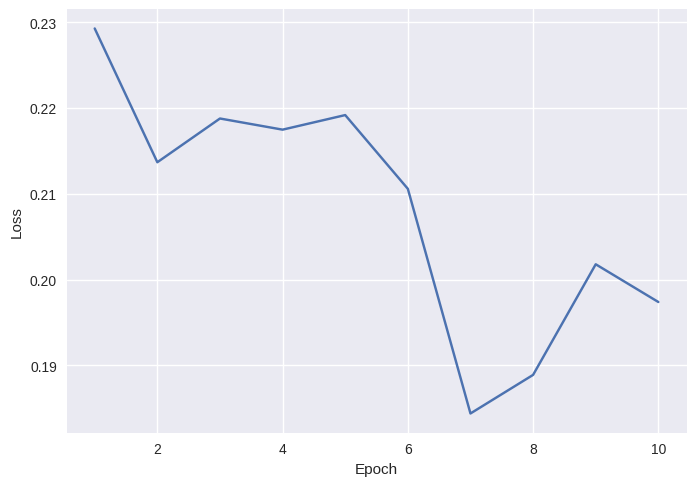

In [14]:
# plotting the loss vs epoch curve
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn')
plt.plot(epoch, loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Performance Analysis of RBM in terms of Test Mean Absolute Error
test_loss = 0
s = 0.
for i in range(14685):
    
    vt = test_set[i:i + 1]
    
    # BLIND WALK BY 1-STEP CD....
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(vt)
        _,v = rbm.sample_v(h)
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1
print('test_loss: '+str(test_loss/s))

test_loss: tensor(0.1786)


In [ ]:
# getting the recommended ratings on the Training Set
answer_train = np.ones((58736, 100))
for i in range(58736):
    #v = training_set[id_user:id_user + 1]
    vt = training_set[i:i + 1]
    
    # BLIND WALK BY 1-STEP CD....
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(vt)
        _,v = rbm.sample_v(h)
        answer_train[i] = np.array(v)

In [ ]:
# getting the recommended ratings on the Test Set
answer_test = np.ones((14685, 100))
for i in range(14685):
    vt = test_set[i:i + 1]
    
    # BLIND WALK BY 1-STEP CD....
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(vt)
        _,v = rbm.sample_v(h)
        answer_test[i] = np.array(v)

In [ ]:
# concatenating the recommended ratings of the training and test set
answer = np.concatenate((answer_train, answer_test), axis = 0)

In [ ]:
# saving the recommended ratings in array-form into a csv file
np.savetxt("answer.csv", answer, delimiter = ",")

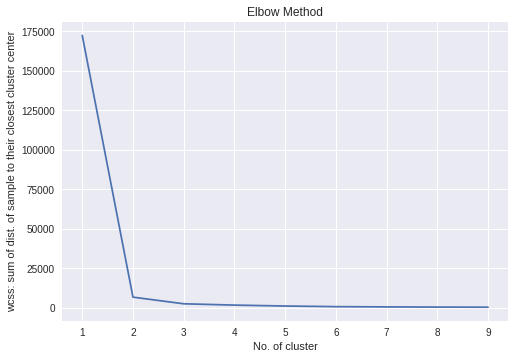

In [ ]:
# elbow method applied on recommended ratings dataset (D1) to select optimum number of clusters

from sklearn.cluster import KMeans
wcss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,init='k-means++',)
    kmeans.fit(answer)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,10),wcss)
plt.title('Elbow Method')
plt.xlabel('No. of cluster')
plt.ylabel('wcss: sum of dist. of sample to their closest cluster center')
plt.show()

The optimum number of clusters is found to be 3

In [ ]:
# concatenating the original training and test datasets and filling the missing ratings by the recommended ratings - D2
x = np.concatenate((training_set, test_set), axis = 0)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        if x[i,j] == -1:
            x[i,j] = answer[i,j]

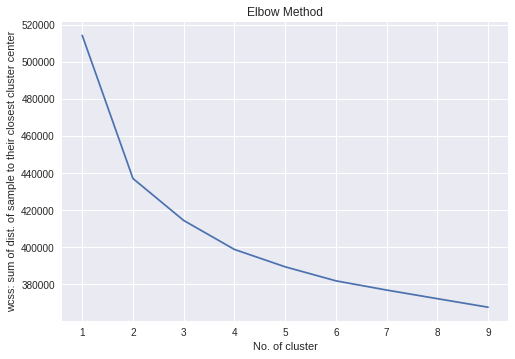

In [ ]:
# elbow method applied on D2 to select optimum number of clusters

wcss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,init='k-means++',)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,10),wcss)
plt.title('Elbow Method')
plt.xlabel('No. of cluster')
plt.ylabel('wcss: sum of dist. of sample to their closest cluster center')
plt.show()

No perfect elbow is obtained within 10 clusters. So, applying k-Means on D1 and visualizing the clusters on D2. The Cluster Visualization is done in the notebook, Preference_Visualization.ipynb

In [ ]:
# applying k-Means Clustering using 3 clusters on D1
kmeans = KMeans(n_clusters=3)
kmeans = kmeans.fit(answer)

In [ ]:
# saving the k-Means Model into pkl file (model serialization)
from sklearn.externals import joblib
joblib.dump(kmeans, 'answer.pkl')

['answer.pkl']